In [1]:
#importing necessary libraries
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# initializing spark environment

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

# connect to S3

In [4]:
#read into spark dataframe from csv in S3
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'cr2st/house.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

,No,transaction date,age,distance to the nearest MRT station,convenience stores,X5 latitude,X6 longitude,price
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.417,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.417,17.9,1783.18000,3,24.96731,121.51486,22.1


In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_location))

In [6]:
df

DataFrame[No: bigint, transaction date: double, age: double, distance to the nearest MRT station: double, convenience stores: bigint, X5 latitude: double, X6 longitude: double, price: double]

In [7]:
#write parquet to S3
parquetPath = '/home/ec2-user/SageMaker/tmp-pqt'
df.write.parquet(parquetPath)

AnalysisException: 'path file:/home/ec2-user/SageMaker/tmp-pqt already exists.;'

In [8]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "cr2st/pqt/"+f)


In [9]:
#write to spark dataframe from parquet
df = sqlc.read.parquet(parquetPath)
df

DataFrame[alpha: bigint, beta: bigint, gamma: bigint]

# Using MLlib

In [66]:
# setup a sample dataframe
bucket='odl-spark19spds6003-001'
data_key = 'cr2st/house.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)

In [67]:
df = sqlc.createDataFrame(pddf)

In [68]:
display(df)

DataFrame[No: bigint, transaction date: double, age: double, distance to the nearest MRT station: double, convenience stores: bigint, X5 latitude: double, X6 longitude: double, price: double]

In [70]:
from pyspark.sql.types import DoubleType

df = df.withColumn("age", df["age"].cast("long"))
df = df.withColumn("distance", df["distance to the nearest MRT station"].cast("long"))
df = df.withColumn("convenience stores", df["convenience stores"].cast("long"))
#df = df.withColumn("latitude", df["latitude"].cast("long"))
#df = df.withColumn("longitude", df["longitude"].cast("long"))
df = df.withColumn("price", df["price"].cast("long"))

In [71]:
#view schema
df.printSchema()

root
 |-- No: long (nullable = true)
 |-- transaction date: double (nullable = true)
 |-- age: long (nullable = true)
 |-- distance to the nearest MRT station: double (nullable = true)
 |-- convenience stores: long (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- price: long (nullable = true)
 |-- distance: long (nullable = true)



In [47]:
#View top 3 rows
df.take(3)

[Row(No=1, transaction date=2012.9170000000001, age=32, distance to the nearest MRT station=84.87881999999999, convenience stores=10, X5 latitude=24.982979999999998, X6 longitude=121.54024, price=37, distance=84),
 Row(No=2, transaction date=2012.9170000000001, age=19, distance to the nearest MRT station=306.5947, convenience stores=9, X5 latitude=24.980339999999998, X6 longitude=121.53951, price=42, distance=306),
 Row(No=3, transaction date=2013.5829999999999, age=13, distance to the nearest MRT station=561.9845, convenience stores=5, X5 latitude=24.987460000000002, X6 longitude=121.54391000000001, price=47, distance=561)]

In [48]:
#correlation analysis to see which features affect each other
print("Pearson's r(house age,house price of unit area) = {}".format(df.corr('age', 'price')))
print("Pearson's r(dist from MRT,house price of unit area) = {}".format(df.corr('distance to the nearest MRT station', 'price')))
print("Pearson's r(number of convenience stores, house price of unit area) = {}".format(df.corr('convenience stores', 'price')))
#print("Pearson's r(latitude,house price of unit area) = {}".format(df.corr('X5 latitude', 'Y house price of unit area')))
#print("Pearson's r(longitude,house price of unit area) = {}".format(df.corr('X6 longitude', 'Y house price of unit area')))

Pearson's r(house age,house price of unit area) = -0.20893310047579913
Pearson's r(dist from MRT,house price of unit area) = -0.6729099921008548
Pearson's r(number of convenience stores, house price of unit area) = 0.5710771532363268


In [49]:
#selecting two variables for analysis
df = df.select("distance","price")

In [50]:
#create a training and testing datasets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 331, test set N = 83


In [51]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [52]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("price", "oneElementVec(distance) as distance")
testDF = testDF.selectExpr("price", "oneElementVec(distance) as distance")

print(testDF.orderBy(testDF.price.desc()).limit(5))

DataFrame[price: bigint, distance: vector]


In [53]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("price", "label").withColumnRenamed("distance", "features")
testDF = testDF.withColumnRenamed("price", "label").withColumnRenamed("distance", "features")

LINEAR REGRESSION

In [54]:
#starting linear regression
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [55]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [56]:
#transforming test set to get predictions
#appending column 'prediction' tp dataframe
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=73, features=DenseVector([292.0]), prediction=42.695986256169085), Row(label=71, features=DenseVector([292.0]), prediction=42.695986256169085), Row(label=70, features=DenseVector([292.0]), prediction=42.695986256169085), Row(label=63, features=DenseVector([281.0]), prediction=42.772721713223724), Row(label=62, features=DenseVector([56.0]), prediction=44.34231060752312)]


MODEL EVALUATION

In [57]:
#model evaluation
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [58]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [59]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

10.009236410874461

In [60]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.45680120418226455

# VISUALIZATIONS

In [79]:
from pyspark.sql import Row
from pyspark.sql.functions import avg
import seaborn as sns

In [80]:
df.printSchema()

root
 |-- No: long (nullable = true)
 |-- transaction date: double (nullable = true)
 |-- age: long (nullable = true)
 |-- distance to the nearest MRT station: double (nullable = true)
 |-- convenience stores: long (nullable = true)
 |-- X5 latitude: double (nullable = true)
 |-- X6 longitude: double (nullable = true)
 |-- price: long (nullable = true)
 |-- distance: long (nullable = true)



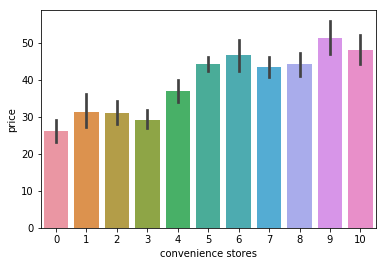

In [85]:
data = df.toPandas()
sns.barplot(x="convenience stores", y="price", data=data)

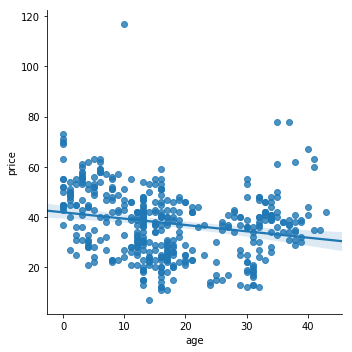

In [94]:
sns.lmplot(x="age", y="price", data=data)

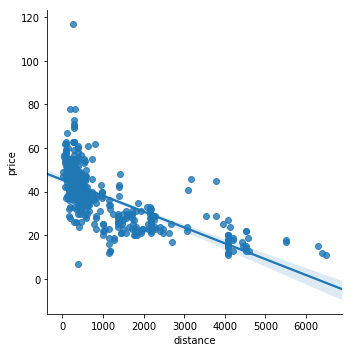

In [95]:
sns.lmplot(x="distance", y="price", data=data)